# UDS Final Project
## Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import dame_flame
from statsmodels.stats.weightstats import ttest_ind
from scipy import stats

In [2]:
# Read the data
df = pd.read_csv('https://raw.githubusercontent.com/MIDS-at-Duke/uds-2023-team-1/main/30_intermediate_files/complete_data.csv?token=GHSAT0AAAAAAB5CQTOTC75IJJC5PL5TDC7KZB67T3Q')
df.head()

,Unnamed: 0,Unnamed: 0_x,startdate,recordeddate,responseid,age,sex_birth,gender_male,gender_female,gender_transm,...,first_gen,week,state_abb,Unnamed: 0_y,week-year,state,new_case,state_new,2020,cases_per_10k
0,0,0,2022-04-11 15:09:58,2022-05-03 09:50:02,R_AuF1Zh0r7wJJY3L,19.0,2.0,1.0,0.0,0.0,...,False,18-2022,CA,2225,18-2022,CA,53178,California,39501653,13.462221
1,1,1,2022-04-17 04:27:57,2022-04-17 04:48:29,R_3nI424DBkE5Ixmt,19.0,1.0,0.0,1.0,0.0,...,False,16-2022,CA,1985,16-2022,CA,37047,California,39501653,9.378595
2,2,2,2022-04-22 09:54:31,2022-04-22 13:49:38,R_32J8GAWh6IOIYxm,20.0,2.0,1.0,0.0,0.0,...,True,16-2022,CA,1985,16-2022,CA,37047,California,39501653,9.378595
3,3,3,2022-04-13 18:48:59,2022-05-03 09:52:47,R_1lizI3iHB2UE7O1,18.0,2.0,1.0,0.0,0.0,...,NaN,18-2022,CA,2225,18-2022,CA,53178,California,39501653,13.462221
4,4,4,2022-04-21 17:14:42,2022-05-03 09:56:15,R_3ELrwNOuqQ7bzmP,49.0,1.0,0.0,1.0,0.0,...,False,18-2022,CA,2225,18-2022,CA,53178,California,39501653,13.462221


## Data Cleaning

1. Remove unnecessary columns
2. Remove outliers
3. Fill in missing values:
- remove rows where target or treatment variables missing
- remove columns with over 50k  missing values making imputation practically infeasible
- fill in "unknown" or "other" when suitable
- fill in "0s" or "1s" for suitable fields. Assume most likely (most frequent) value.
- knn imputation for numerical and multicategorical fields

In [3]:
# removing outliers
df[df['hours_work_paid'] > 120] = np.nan
df[df['sleep_wknight'] >= 24] = np.nan

## Missing Values

In [4]:
# let's delete rows where the target variable anxiety treatment is missing
df.dropna(subset=['anxiety'], inplace=True)
df.dropna(subset=['covid_clsformat'], inplace=True)
print(df.shape)

(84870, 96)


In [5]:
def fill_in(df, cols, value = 1):
    for col in cols:
        df[col] = df[col].fillna(value)
    return df

In [6]:
# fill in with 1s
cols_1 = ['food_notlast', 'food_worry', 'deport_worry', 'alc_any', 'enroll', 'children_dep'] #alc_any and enroll harder to justify

# fill in with 0s
cols_0 = ['disab_2', 'sub_cig', 'sub_any', 'dx_any', 'meds_any', 'sui_idea', 'lone_isolated', 'assault_emo', 'hours_work_paid', 'international']

# fill in with 3s
cols_3 = ['disab_1']

# fill in with 7s - unknown
cols_7 = ['educ_par2', 'educ_par1', 'positive_mental_health', 'sex_birth']

# fill in with False
cols_false = ['first_gen']

# knn imputation
cols_knn_imp = ['knowwher', 'sleep_wknight', 'exerc', 'persist', 'yr_sch', 'timestud', 'finpast', 'fincur', 'abuse_life', 'satisfied_overall']

# columns to delete
cols_del = ['q2_wtg_3', 'q2_wtg_6_1', 'env_mh', 'camp_supp', 'percneed', 'Unnamed: 0', 'Unnamed: 0_x']

# categorical imputation - most frequent - hard to justify, but ok for now
cols_q = ['risk_of_depression']

In [7]:
df = fill_in(df, cols_1, 1)
df = fill_in(df, cols_0, 0)
df = fill_in(df, cols_3, 3)
df = fill_in(df, cols_7, 7)
df = fill_in(df, cols_false, False)

In [8]:
# delete unnecessary columns
df.drop(columns=cols_del, inplace=True, axis=1)

In [9]:
# KNN imputation
imputer = KNNImputer(n_neighbors=1)
imputed = imputer.fit_transform(df[df.describe().columns.to_list()])

In [10]:
for col in df.describe().columns.to_list():
    df[col] = imputed[:, df.describe().columns.to_list().index(col)]

In [11]:
# most frequent imputation
df[cols_q[0]] = df[cols_q[0]].fillna(df[cols_q[0]].mode().iloc[0])

In [12]:
# create binary variable for treatment
df['is_online'] = df['covid_clsformat'].replace({1: 0, 2: 1, 3: 1}).copy()

# remove rows where is_online = 4. These are other and we can exclude those.
df = df[df['is_online'] != 4]

# remove covid_clsformat
df.drop(columns=['covid_clsformat'], inplace=True, axis=1)

In [21]:
# run this if you just want all the data
df.to_csv('all_data.csv')

## Matching Process

In [14]:
# create binary variable for treatment
df['is_online'] = df['covid_clsformat'].replace({1: 0, 2: 1, 3: 1}).copy()

# remove rows where is_online = 4. These are other and we can exclude those.
df = df[df['is_online'] != 4]

# remove covid_clsformat
df.drop(columns=['covid_clsformat'], inplace=True, axis=1)

KeyError: 'covid_clsformat'

In [16]:
# convert categorical to numerical for matching
df['positive_mental_health'] = df['positive_mental_health'].replace({"Not flourishing": 0, "Flourishing": 1})
df['risk_of_depression'] = df['risk_of_depression'].replace({"Mild": 1, "Minimal": 2, "Moderate": 3, "Moderately severe": 4, "Severe": 5})
df['first_gen'] = df['first_gen'].replace({False: 0, True: 1})

In [17]:
# print shape
print("The shape of the data is: ", df.shape)

The shape of the data is:  (83024, 89)


We want to limit our number of columns to consider when doing matching. We'll only going to match on fields that are highly correlated (> 0.15) with our treatment and outcome variables.

In [18]:
# create a dataframe to show correlation between output and treatment variables
X = df.drop(columns=['anxiety', 'is_online']).copy()
anx = df['anxiety'].copy()
online = df['is_online'].copy()
corr_data = pd.concat([X, anx], axis=1)
corr_anxiety = corr_data.corr()['anxiety'].sort_values(ascending=False)
corr_data = pd.concat([X, online], axis=1)
corr_online = corr_data.corr()['is_online'].sort_values(ascending=False)

In [21]:
df.columns

Index(['startdate', 'recordeddate', 'responseid', 'age', 'sex_birth',
       'gender_male', 'gender_female', 'gender_transm', 'gender_transf',
       'sexual_other', 'gender_nonbin', 'gender_selfid', 'sexual_h',
       'sexual_l', 'sexual_g', 'sexual_bi', 'sexual_queer', 'sexual_quest',
       'sexual_asexual', 'sexual_pan', 'race_black', 'race_ainaan',
       'race_asian', 'race_his', 'race_pi', 'race_mides', 'race_white',
       'race_other', 'international', 'educ_par1', 'educ_par2',
       'scholarship_status_1', 'children_dep', 'hours_work_paid', 'transfer',
       'yr_sch', 'enroll', 'persist', 'disab_1', 'disab_2',
       'positive_mental_health', 'risk_of_depression', 'anxiety', 'timestud',
       'sui_idea', 'lone_isolated', 'abuse_life', 'assault_emo', 'alc_any',
       'sub_cig', 'sub_any', 'exerc', 'sleep_wknight', 'dx_any', 'knowwher',
       'meds_any', 'degree_ass', 'degree_bach', 'degree_ma', 'degree_jd',
       'degree_md', 'degree_phd', 'degree_other', 'degree_nd', 'g

In [19]:
cols1 = corr_anxiety[abs(corr_anxiety) > 0.20].index.to_list()
cols1

['anxiety',
 'risk_of_depression',
 'lone_isolated',
 'dx_any',
 'sui_idea',
 'persist',
 'meds_any',
 'abuse_life',
 'sexual_h',
 'finpast',
 'satisfied_overall',
 'fincur',
 'positive_mental_health']

In [20]:
cols2 = corr_online[abs(corr_online) > 0.20].index.to_list()
cols2

['is_online', 'degree_ass', 'hours_work_paid', 'age', 'enroll', 'degree_bach']

In [39]:
dame_model = dame_flame.matching.FLAME(verbose = 3, want_pe = True, early_stop_iterations=15)
columns_to_use = list(set(cols1 + cols2)) + ['cases_per_10k'] + ['sex_birth', 'gender_male', 'sexual_bi', 'disab_1', 'assault_emo', 'sleep_wknight']

In [40]:
dame_model.fit(
    df[columns_to_use],
    treatment_column_name='is_online',
    outcome_column_name='anxiety',
)
result = dame_model.predict(df[columns_to_use])

Completed iteration 0 of matching
	Number of matched groups formed in total:  36
	Unmatched treated units:  38266 out of a total of  38302 treated units
	Unmatched control units:  44684 out of a total of  44722 control units
	Number of matches made this iteration:  74
	Number of matches made so far:  74
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  36.057745232656835
Completed iteration 1 of matching
	Number of matched groups formed in total:  393
	Unmatched treated units:  37856 out of a total of  38302 treated units
	Unmatched control units:  44172 out of a total of  44722 control units
	Number of matches made this iteration:  922
	Number of matches made so far:  996
	Covariates dropped so far:  cases_per_10k
	Predictive error of covariate set used to match:  36.05853423001013
Completed iteration 2 of matching
	Number of matched groups formed in total:  448
	Unmatched treated units:  37810 out of a total of  38302 treated units
	Unmatched contr

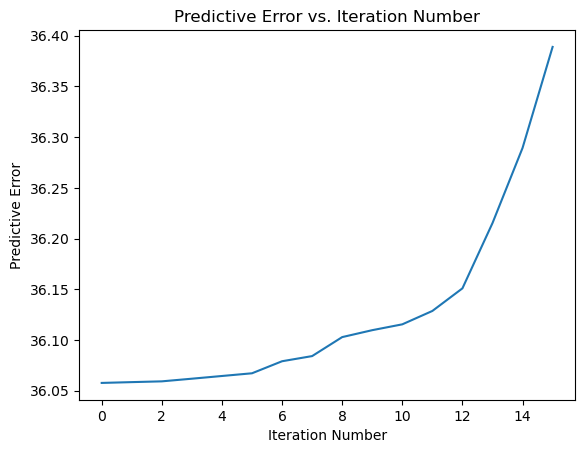

In [42]:
plt.plot(dame_model.pe_each_iter)
plt.title("Predictive Error vs. Iteration Number")
plt.xlabel("Iteration Number")
plt.ylabel("Predictive Error")
plt.show()

In [43]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    #assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [44]:
matched_results = get_dataframe(dame_model, result)

In [45]:
matched_final = df.loc[matched_results.index.to_list()].copy()
matched_final['weights'] = matched_results['weights'].copy()
matched_final['match_group_size'] = matched_results['match_group_size'].copy()
matched_final['match_group'] = matched_results['match_group'].copy()


In [46]:
matched_final

,startdate,recordeddate,responseid,age,sex_birth,gender_male,gender_female,gender_transm,gender_transf,sexual_other,...,week-year,state,new_case,state_new,2020,cases_per_10k,is_online,weights,match_group_size,match_group
0,2022-04-11 15:09:58,2022-05-03 09:50:02,R_AuF1Zh0r7wJJY3L,19.0,2.0,1.0,0.0,0.0,0.0,0.0,...,18-2022,CA,53178.0,California,39501653.0,13.462221,1.0,1.000000,3.0,21607.0
1,2022-04-17 04:27:57,2022-04-17 04:48:29,R_3nI424DBkE5Ixmt,19.0,1.0,0.0,1.0,0.0,0.0,0.0,...,16-2022,CA,37047.0,California,39501653.0,9.378595,1.0,1.000000,15.0,21691.0
2,2022-04-22 09:54:31,2022-04-22 13:49:38,R_32J8GAWh6IOIYxm,20.0,2.0,1.0,0.0,0.0,0.0,0.0,...,16-2022,CA,37047.0,California,39501653.0,9.378595,1.0,1.000000,24.0,22103.0
5,2022-04-11 12:35:38,2022-04-11 12:59:31,R_72I28iy8iqGtOnL,27.0,2.0,1.0,0.0,0.0,0.0,0.0,...,15-2022,CA,25540.0,California,39501653.0,6.465552,0.0,0.565514,10.0,25442.0
6,2022-04-12 03:53:14,2022-04-12 04:28:27,R_2SAm0W5LbJvYjn0,21.0,1.0,0.0,1.0,0.0,0.0,0.0,...,15-2022,CA,25540.0,California,39501653.0,6.465552,0.0,1.319534,2.0,9595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95850,2022-03-07 14:57:10,2022-03-07 15:31:12,R_32XRK74koJFNke2,19.0,1.0,0.0,1.0,0.0,0.0,0.0,...,10-2022,WA,8093.0,Washington,7724031.0,10.477690,0.0,0.615782,22.0,16651.0
95856,2022-02-28 11:23:31,2022-03-14 12:44:17,R_1LcaZKgoUQLvN1o,20.0,1.0,0.0,1.0,0.0,0.0,0.0,...,11-2022,WA,6788.0,Washington,7724031.0,8.788157,0.0,1.319534,4.0,22541.0
95857,2022-02-24 20:04:13,2022-02-24 20:50:35,R_7NYtlZIPoo4LyUh,20.0,2.0,1.0,0.0,0.0,0.0,0.0,...,08-2022,WA,18325.0,Washington,7724031.0,23.724659,0.0,0.659767,12.0,22217.0
95858,2022-03-01 14:24:55,2022-03-01 21:51:29,R_2Ep0PMy8iM5lXmG,21.0,1.0,0.0,0.0,0.0,0.0,0.0,...,09-2022,WA,13386.0,Washington,7724031.0,17.330329,0.0,0.853816,28.0,23405.0


### Join with COVID dataset

In [46]:
# read in cases
cases = pd.read_csv('https://raw.githubusercontent.com/MIDS-at-Duke/uds-2023-team-1/main/10_data/cases_by_month_year.csv?token=GHSAT0AAAAAAB5CQTOTYUECXVGLKFD5OO6SZB26C2A')

In [49]:
final_df = matched_final.merge(cases, how = "left", left_on = ["week", "state_abb"], right_on = ["week-year", "state"]).drop(columns = ["week", "state_abb", "Unnamed: 0"])

In [51]:
final_df.to_csv('matched_data.csv', index = False)

### Chi-Square Test To Ensure Balance

In [47]:
final_df = matched_final.copy()

In [52]:
for col in columns_to_use:
    frequencies = pd.crosstab(final_df[col], final_df['is_online'])
    chi2, p, dof, ex = stats.chi2_contingency(frequencies)
    print("The p-value of {} the chi-squared test is: {:.4f}".format(col, p))

The p-value of the chi-squared test is: 0.0000
